### File Explanation

**trainRNN_HBTRC_AttentionModel_learningRate.ipynb:**
<br> This notebook is to load HBTRC examples from 'preprocessData.pickle', create an "Attention Network" and train the network with respect to a range of learning rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model from fixed length sequences (function: **dynamicLSTM_Attention** in **trainRNN_network_utils.py**)
<br> 5) Create an attention mechanism based on a fully-connected layer of states and output, which is followed by a tanh layer to calculate scores. Then, calculate attention weights and context vector using softmax and dense layers 
<br> 6) Create a single output from a concatenation of context vectors of gene A and gene B
<br> 7) Pass the output through a **dense** layer and make prediction
<br> 8) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 9) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 10) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 11) Save them in "resultsAttentionLearningRate_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 5) **attention_matrixA**: Attention weights of gene A, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 6) **attention_matrixB**: Attention weights of gene B, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 7) **tst_prediction**: Test predictions, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [3]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [4]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropout = 0.4                                       # dropout percentage

## Training data
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [5]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
attention_matrixA = {}
attention_matrixB = {}
tst_prediction = {}

for learning_rate in learning_rates:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM_Attention(rSnpRnaA_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_A = current_state_A[-1].h

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM_Attention(rSnpRnaB_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_B = current_state_B[-1].h

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    context_vectorA, attention_weightsA = attention(hidden_state_A, hidden_output_A, n_hidden)
    context_vectorB, attention_weightsB = attention(hidden_state_B, hidden_output_B, n_hidden)

    encoding = tf.concat((context_vectorA, context_vectorB), axis=1)

    # Dense Layer
    logits = tf.layers.dense(encoding,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.4),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.argmax(logits, 1)

    l2 = lambda_l2_reg * sum(
        tf.nn.l2_loss(tf_var)
            for tf_var in tf.trainable_variables()
            if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(prediction, tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Precision and recall
    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC               
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            

            if epoch_idx == (n_epoch-1):

                for i in range(rSnpRnaA_tst_nXNS.shape[0]):
                    rSnpRnaA_tst_nXNSA = np.expand_dims(rSnpRnaA_tst_nXNS[i], axis=0)
                    rSnpRnaB_tst_nXNSB = np.expand_dims(rSnpRnaB_tst_nXNS[i], axis=0)
                    rRelated_tst_nXC_ = np.expand_dims(rRelated_tst_nXC[i], axis=0)

                    pred, at_weightA, at_weightB = sess.run(
                        [prediction, attention_weightsA, attention_weightsB],
                        feed_dict = {
                                rSnpRnaA_pXNS: rSnpRnaA_tst_nXNSA,
                                rSnpRnaB_pXNS: rSnpRnaB_tst_nXNSB,
                                rRelated_pXC: rRelated_tst_nXC_
                                }) 

                    at_weightA = np.reshape(at_weightA, (-1, 1))
                    at_weightB = np.reshape(at_weightB, (-1, 1))

                    attention_matrixA[dropout] = at_weightA
                    attention_matrixB[dropout] = at_weightB                    
                    tst_prediction[dropout] = pred
    
        trainLosses[learning_rate] = train_losses
        testLosses[learning_rate] = test_losses
        trainAccuracy[learning_rate] = train_accuracies
        F1_scores[learning_rate] = test_f1_score
        print("Optimisation finished!")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.9121828079223633: Accuracy = 0.35333332419395447
Performance on test set: : Loss = 1.9455277919769287: Accuracy = 0.5867768470801786

Data shuffled. Epoch:

Performance on training data: Loss = 1.7186532020568848: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 2.6994285583496094: Accuracy = 0.4955557133014684

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.5348312854766846: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 2.5223984718322754: Accuracy = 0.48942182678504936

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.5844789743423462: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 2.734052896499634: Accuracy = 0.48564858861973026

Data shuffled. Epoch:  30
Performance on training data: Loss = 1.5665172338485718: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 2.366190195083618: Accuracy = 0.4798497705187726

Data shuffled. Epoch:  31
Performance on training data: Loss = 1.5422395467758179: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 3.119229555130005: Accuracy = 0.4787151929943121

Data shuffled. Epoch:  32
Performance

Performance on training data: Loss = 0.9704129099845886: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 2.055281162261963: Accuracy = 0.4680097361007157

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.8906455636024475: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.869518756866455: Accuracy = 0.46867416883225094

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.9247666597366333: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 2.6579179763793945: Accuracy = 0.46828330328530016

Data shuffled. Epoch:  72
Performance on training data: Loss = 0.8622519969940186: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 2.175828456878662: Accuracy = 0.46756682309353254

Data shuffled. Epoch:  73
Performance on training data: Loss = 1.1260111331939697: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.9055734872817993: Accuracy = 0.4679200954726632

Data shuffled. Epoch:  74
Performance

Performance on training data: Loss = 1.025962471961975: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.5171947479248047: Accuracy = 0.5053280432195625

Data shuffled. Epoch:  112
Performance on training data: Loss = 1.0474979877471924: Accuracy = 0.6133333444595337
Performance on test set: : Loss = 1.4841759204864502: Accuracy = 0.5085301718855708

Data shuffled. Epoch:  113
Performance on training data: Loss = 1.0772243738174438: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.601017951965332: Accuracy = 0.5108267179939499

Data shuffled. Epoch:  114
Performance on training data: Loss = 1.0733009576797485: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.5291813611984253: Accuracy = 0.5139623866739834

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.9487298727035522: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.6396379470825195: Accuracy = 0.5156578114340349

Data shuffled. Epoch:  116
Perform

Performance on training data: Loss = 1.0810670852661133: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.942222237586975: Accuracy = 0.5427742758080208

Data shuffled. Epoch:  154
Performance on training data: Loss = 1.095054268836975: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.6844587326049805: Accuracy = 0.5429245191483582

Data shuffled. Epoch:  155
Performance on training data: Loss = 1.0682799816131592: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 2.040057897567749: Accuracy = 0.5432863416461597

Data shuffled. Epoch:  156
Performance on training data: Loss = 0.9613749384880066: Accuracy = 0.6133333444595337
Performance on test set: : Loss = 1.8713526725769043: Accuracy = 0.5429965050182929

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.9573572874069214: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.7108383178710938: Accuracy = 0.5428462884969489

Data shuffled. Epoch:  158
Performan

Performance on training data: Loss = 17.077199935913086: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 17.9740047454834: Accuracy = 0.598987373427667

Data shuffled. Epoch:  196
Performance on training data: Loss = 17.133411407470703: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 17.62476348876953: Accuracy = 0.6003365200413531

Data shuffled. Epoch:  197
Performance on training data: Loss = 17.20368194580078: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 18.115564346313477: Accuracy = 0.601743534234653

Data shuffled. Epoch:  198
Performance on training data: Loss = 17.197139739990234: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 17.91045379638672: Accuracy = 0.6030027179877728

Data shuffled. Epoch:  199
Performance on training data: Loss = 17.042163848876953: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 17.67203140258789: Accuracy = 0.6041857645985735

Optimisation finished!
Data shuffled. Ep

Performance on training data: Loss = 0.4628584682941437: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 3.880671977996826: Accuracy = 0.4310579105764385

Data shuffled. Epoch:  38
Performance on training data: Loss = 0.44118738174438477: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 3.289555549621582: Accuracy = 0.43558008753241445

Data shuffled. Epoch:  39
Performance on training data: Loss = 0.5687913298606873: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 3.959049701690674: Accuracy = 0.43902737227835187

Data shuffled. Epoch:  40
Performance on training data: Loss = 0.4908507168292999: Accuracy = 0.746666669845581
Performance on test set: : Loss = 2.47226619720459: Accuracy = 0.44132353849003025

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.5378652811050415: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 2.287203073501587: Accuracy = 0.44140899302653724

Data shuffled. Epoch:  42
Performance 

Performance on training data: Loss = 0.4548629820346832: Accuracy = 0.800000011920929
Performance on test set: : Loss = 3.496398687362671: Accuracy = 0.4497402573602046

Data shuffled. Epoch:  80
Performance on training data: Loss = 0.4320252537727356: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 3.4958157539367676: Accuracy = 0.44863108266313756

Data shuffled. Epoch:  81
Performance on training data: Loss = 0.45649293065071106: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 3.0523433685302734: Accuracy = 0.4487568653264321

Data shuffled. Epoch:  82
Performance on training data: Loss = 0.4383958876132965: Accuracy = 0.800000011920929
Performance on test set: : Loss = 3.289369821548462: Accuracy = 0.44868583144802376

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.44069182872772217: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 4.12025785446167: Accuracy = 0.44875044056424024

Data shuffled. Epoch:  84
Performance

Performance on training data: Loss = 0.36613285541534424: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 4.705186367034912: Accuracy = 0.4371987023396528

Data shuffled. Epoch:  122
Performance on training data: Loss = 0.41508060693740845: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 5.28413200378418: Accuracy = 0.4368970642724506

Data shuffled. Epoch:  123
Performance on training data: Loss = 0.3904159665107727: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 4.408450126647949: Accuracy = 0.4366358390936475

Data shuffled. Epoch:  124
Performance on training data: Loss = 0.42470166087150574: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 4.797094821929932: Accuracy = 0.43682109864535057

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.4143836796283722: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 4.139372825622559: Accuracy = 0.4374043610811575

Data shuffled. Epoch:  126
Perform

Performance on training data: Loss = 0.4159475862979889: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 3.852503538131714: Accuracy = 0.45902593055162005

Data shuffled. Epoch:  164
Performance on training data: Loss = 0.4108785390853882: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 3.545590877532959: Accuracy = 0.45935996101952425

Data shuffled. Epoch:  165
Performance on training data: Loss = 0.4279060363769531: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 3.6212007999420166: Accuracy = 0.4593803457584627

Data shuffled. Epoch:  166
Performance on training data: Loss = 0.4315260350704193: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 3.306713104248047: Accuracy = 0.45989888467451373

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.4045422673225403: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 3.4638092517852783: Accuracy = 0.4608548747175494

Data shuffled. Epoch:  168
Perfo

Performance on training data: Loss = 1.0630379915237427: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1918379068374634: Accuracy = 0.5319006181860584

Data shuffled. Epoch:  6
Performance on training data: Loss = 1.063977837562561: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1890748739242554: Accuracy = 0.5262242819657069

Data shuffled. Epoch:  7
Performance on training data: Loss = 1.0319613218307495: Accuracy = 0.4533333480358124
Performance on test set: : Loss = 1.1878743171691895: Accuracy = 0.5220061299796819

Data shuffled. Epoch:  8
Performance on training data: Loss = 0.8346767425537109: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.1698273420333862: Accuracy = 0.5103416406977874

Data shuffled. Epoch:  9
Performance on training data: Loss = 0.8455473184585571: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 1.1878446340560913: Accuracy = 0.4930332233346384

Data shuffled. Epoch:  10
Performance on 

Performance on training data: Loss = 0.46441900730133057: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 1.6555805206298828: Accuracy = 0.6053428291790672

Data shuffled. Epoch:  48
Performance on training data: Loss = 0.4886319041252136: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.5301778316497803: Accuracy = 0.6061478019039896

Data shuffled. Epoch:  49
Performance on training data: Loss = 0.4913129210472107: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.6941465139389038: Accuracy = 0.6068971383832615

Data shuffled. Epoch:  50
Performance on training data: Loss = 0.48665159940719604: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.701117753982544: Accuracy = 0.6066906931884801

Data shuffled. Epoch:  51
Performance on training data: Loss = 0.4557923972606659: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.01033091545105: Accuracy = 0.6061479068013811

Data shuffled. Epoch:  52
Performance 

Performance on training data: Loss = 0.3552074730396271: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 2.1985976696014404: Accuracy = 0.6088798915593012

Data shuffled. Epoch:  90
Performance on training data: Loss = 0.40415045619010925: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.4722900390625: Accuracy = 0.6086669519071572

Data shuffled. Epoch:  91
Performance on training data: Loss = 0.3801691234111786: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.218701124191284: Accuracy = 0.607976143986985

Data shuffled. Epoch:  92
Performance on training data: Loss = 0.40633994340896606: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.1737799644470215: Accuracy = 0.6087056306098045

Data shuffled. Epoch:  93
Performance on training data: Loss = 0.4210304915904999: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.9512615203857422: Accuracy = 0.6088244388302609

Data shuffled. Epoch:  94
Performance o

Performance on training data: Loss = 0.38785436749458313: Accuracy = 0.800000011920929
Performance on test set: : Loss = 2.6653223037719727: Accuracy = 0.619094553585244

Data shuffled. Epoch:  132
Performance on training data: Loss = 0.38764074444770813: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 2.431248188018799: Accuracy = 0.6197906183779428

Data shuffled. Epoch:  133
Performance on training data: Loss = 0.3620818555355072: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 2.4803171157836914: Accuracy = 0.6196346615612588

Data shuffled. Epoch:  134
Performance on training data: Loss = 0.3525186777114868: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 2.2566425800323486: Accuracy = 0.620465353767658

Data shuffled. Epoch:  135
Performance on training data: Loss = 0.4096352159976959: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 2.4311604499816895: Accuracy = 0.6214784955991637

Data shuffled. Epoch:  136
Perform

Performance on training data: Loss = 0.33905646204948425: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 2.855861186981201: Accuracy = 0.6221119646776396

Data shuffled. Epoch:  174
Performance on training data: Loss = 0.34503376483917236: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 3.266380786895752: Accuracy = 0.6222076290522929

Data shuffled. Epoch:  175
Performance on training data: Loss = 0.3351013958454132: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 3.074793815612793: Accuracy = 0.622680003798252

Data shuffled. Epoch:  176
Performance on training data: Loss = 0.37348702549934387: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 3.4347479343414307: Accuracy = 0.6225305793464395

Data shuffled. Epoch:  177
Performance on training data: Loss = 0.31782403588294983: Accuracy = 0.846666693687439
Performance on test set: : Loss = 3.237353801727295: Accuracy = 0.6220380223296823

Data shuffled. Epoch:  178
Perform

Performance on training data: Loss = 0.8302775621414185: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.2686357498168945: Accuracy = 0.667221176703468

Data shuffled. Epoch:  16
Performance on training data: Loss = 0.8026970624923706: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.3346614837646484: Accuracy = 0.6728029903551729

Data shuffled. Epoch:  17
Performance on training data: Loss = 0.784274697303772: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.4255610704421997: Accuracy = 0.6770068214667685

Data shuffled. Epoch:  18
Performance on training data: Loss = 0.7237074971199036: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.2798070907592773: Accuracy = 0.6796315148095811

Data shuffled. Epoch:  19
Performance on training data: Loss = 0.7597252726554871: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.2996472120285034: Accuracy = 0.6823889053433512

Data shuffled. Epoch:  20
Performance 

Performance on training data: Loss = 0.5724638104438782: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.7542665004730225: Accuracy = 0.6990595411210575

Data shuffled. Epoch:  58
Performance on training data: Loss = 0.5404385924339294: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.8894786834716797: Accuracy = 0.6992299607556409

Data shuffled. Epoch:  59
Performance on training data: Loss = 0.5598236322402954: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.6362208127975464: Accuracy = 0.6993843251206739

Data shuffled. Epoch:  60
Performance on training data: Loss = 0.5414929986000061: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.541043996810913: Accuracy = 0.6997815190849506

Data shuffled. Epoch:  61
Performance on training data: Loss = 0.5428739786148071: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.7979929447174072: Accuracy = 0.7002003678896912

Data shuffled. Epoch:  62
Performance

Performance on training data: Loss = 0.4908914566040039: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.8376376628875732: Accuracy = 0.6895414532784551

Data shuffled. Epoch:  100
Performance on training data: Loss = 0.5311437249183655: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.7864131927490234: Accuracy = 0.6888759645107531

Data shuffled. Epoch:  101
Performance on training data: Loss = 0.5243549942970276: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.9027312994003296: Accuracy = 0.6881743156719773

Data shuffled. Epoch:  102
Performance on training data: Loss = 0.5276098847389221: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.642481803894043: Accuracy = 0.6879038079854524

Data shuffled. Epoch:  103
Performance on training data: Loss = 0.5172612071037292: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 1.7444978952407837: Accuracy = 0.6873291059991077

Data shuffled. Epoch:  104
Perfor

Performance on training data: Loss = 0.5069591403007507: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.7720259428024292: Accuracy = 0.6699962155010452

Data shuffled. Epoch:  142
Performance on training data: Loss = 0.5184611678123474: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.7887712717056274: Accuracy = 0.6690398867294076

Data shuffled. Epoch:  143
Performance on training data: Loss = 0.5183588266372681: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.9326598644256592: Accuracy = 0.6681392059205393

Data shuffled. Epoch:  144
Performance on training data: Loss = 0.5154111385345459: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.7258273363113403: Accuracy = 0.6675038440957326

Data shuffled. Epoch:  145
Performance on training data: Loss = 0.5141993761062622: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.9720795154571533: Accuracy = 0.6672523883804525

Data shuffled. Epoch:  146
Perfor

Performance on training data: Loss = 0.488918662071228: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.713205099105835: Accuracy = 0.6533649437867359

Data shuffled. Epoch:  184
Performance on training data: Loss = 0.4964251220226288: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.925333023071289: Accuracy = 0.6530049796271409

Data shuffled. Epoch:  185
Performance on training data: Loss = 0.5032269358634949: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.8595906496047974: Accuracy = 0.6528071046848412

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.48663151264190674: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.8401520252227783: Accuracy = 0.6526680029327332

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.4821251332759857: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.93611741065979: Accuracy = 0.6524020767912827

Data shuffled. Epoch:  188
Performance

Performance on training data: Loss = 1.0853161811828613: Accuracy = 0.4533333480358124
Performance on test set: : Loss = 1.134456992149353: Accuracy = 0.6146256089114295

Data shuffled. Epoch:  26
Performance on training data: Loss = 1.0841562747955322: Accuracy = 0.5133333206176758
Performance on test set: : Loss = 1.1436132192611694: Accuracy = 0.6091242132080216

Data shuffled. Epoch:  27
Performance on training data: Loss = 1.0955647230148315: Accuracy = 0.4466666579246521
Performance on test set: : Loss = 1.149748682975769: Accuracy = 0.6026422036252375

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.0842574834823608: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.1536378860473633: Accuracy = 0.5968439430435829

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.057424545288086: Accuracy = 0.5
Performance on test set: : Loss = 1.158258318901062: Accuracy = 0.5919927057848252

Data shuffled. Epoch:  30
Performance on training data:

Performance on training data: Loss = 0.9162856936454773: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.3249688148498535: Accuracy = 0.44446641940493753

Data shuffled. Epoch:  68
Performance on training data: Loss = 0.922012448310852: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.3380993604660034: Accuracy = 0.4427262641798032

Data shuffled. Epoch:  69
Performance on training data: Loss = 0.9607943892478943: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.3622205257415771: Accuracy = 0.44096912388579057

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.9609952569007874: Accuracy = 0.5066666603088379
Performance on test set: : Loss = 1.3362066745758057: Accuracy = 0.4395701509631844

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.9344921708106995: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.3456848859786987: Accuracy = 0.4378820184662516

Data shuffled. Epoch:  72
Performan

Performance on training data: Loss = 0.8528249859809875: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.5439010858535767: Accuracy = 0.4088159038093846

Data shuffled. Epoch:  110
Performance on training data: Loss = 0.835224986076355: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.544066071510315: Accuracy = 0.4083642969717278

Data shuffled. Epoch:  111
Performance on training data: Loss = 0.8708615899085999: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 1.5623992681503296: Accuracy = 0.4081436810796644

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.8024742007255554: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.5444607734680176: Accuracy = 0.40799016917573344

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.8853675127029419: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.6154097318649292: Accuracy = 0.4078081780571568

Data shuffled. Epoch:  114
Perfor

Performance on training data: Loss = 0.772823691368103: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 1.6538797616958618: Accuracy = 0.40850530328002455

Data shuffled. Epoch:  152
Performance on training data: Loss = 0.7276456952095032: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.5454540252685547: Accuracy = 0.4086902290285

Data shuffled. Epoch:  153
Performance on training data: Loss = 0.7801164388656616: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 1.6238703727722168: Accuracy = 0.4088040431440515

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.7473934888839722: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 1.5955958366394043: Accuracy = 0.40898445700105196

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.7587274312973022: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.578084111213684: Accuracy = 0.4091173444163973

Data shuffled. Epoch:  156
Performa

Performance on training data: Loss = 0.6949091553688049: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.6285006999969482: Accuracy = 0.4156187300832232

Data shuffled. Epoch:  194
Performance on training data: Loss = 0.6637300848960876: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.6906336545944214: Accuracy = 0.41583960209873855

Data shuffled. Epoch:  195
Performance on training data: Loss = 0.6858822703361511: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.56901216506958: Accuracy = 0.41604504297154965

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.6633253693580627: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.6340404748916626: Accuracy = 0.41635753286905386

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.7628681659698486: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.7000912427902222: Accuracy = 0.41666665590348057

Data shuffled. Epoch:  198
Per

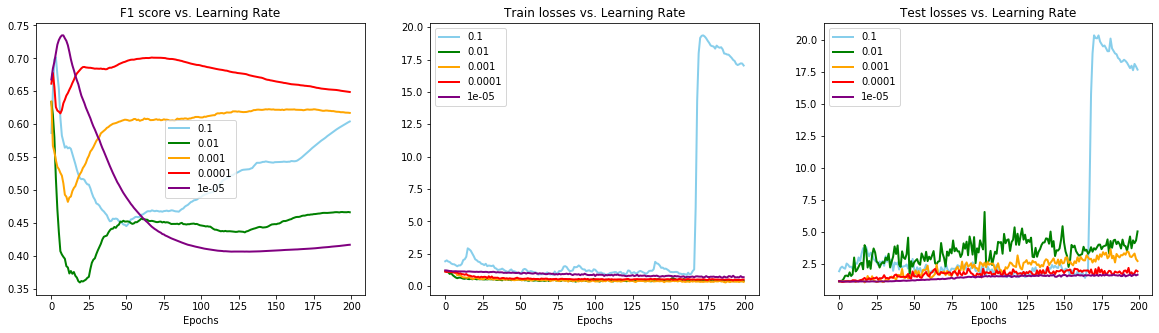

In [6]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Learning Rate")

In [7]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsAttentionLearningRate_HBTRC.pickle', 'wb') as f:
    pickle.dump( rSnpRnaA_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpRnaB_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixA, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixB, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( tst_prediction, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
